In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import cv2
from keras.datasets import mnist, cifar10
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

In [4]:
# Function to perform block-wise DCT
def blockwise_dct(image, block_size=8):
    """Applies DCT block-wise to an image."""
    h, w = image.shape
    dct_image = np.zeros_like(image, dtype=np.float32)
    
    # Process the image in block sizes
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i + block_size, j:j + block_size]
            # Apply DCT to the block
            dct_block = cv2.dct(np.float32(block))
            dct_image[i:i + block_size, j:j + block_size] = dct_block
            
    return dct_image

# Function to perform block-wise Inverse DCT
def blockwise_idct(dct_image, block_size=8):
    """Applies Inverse DCT block-wise to an image."""
    h, w = dct_image.shape
    image_reconstructed = np.zeros_like(dct_image, dtype=np.float32)
    
    # Process the DCT image in block sizes
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            dct_block = dct_image[i:i + block_size, j:j + block_size]
            # Apply Inverse DCT to the block
            block = cv2.idct(dct_block)
            image_reconstructed[i:i + block_size, j:j + block_size] = block
            
    return image_reconstructed

In [5]:
# Function to apply quantization to the DCT coefficients (block-wise)
def blockwise_quantize_dct(dct_image, quant_matrix, block_size=8):
    """Quantizes the DCT coefficients block-wise."""
    h, w = dct_image.shape
    quantized_dct = np.zeros_like(dct_image)
    
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = dct_image[i:i + block_size, j:j + block_size]
            quantized_block = np.round(block / quant_matrix)  # Quantization
            quantized_dct[i:i + block_size, j:j + block_size] = quantized_block
            
    return quantized_dct

# Function to dequantize the DCT coefficients (block-wise)
def blockwise_dequantize_dct(quantized_dct, quant_matrix, block_size=8):
    """Dequantizes the DCT coefficients block-wise."""
    h, w = quantized_dct.shape
    dequantized_dct = np.zeros_like(quantized_dct)
    
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = quantized_dct[i:i + block_size, j:j + block_size]
            dequantized_block = block * quant_matrix  # Dequantization
            dequantized_dct[i:i + block_size, j:j + block_size] = dequantized_block
            
    return dequantized_dct

In [6]:
# Load the image from your Google Drive in grayscale mode (0 indicates grayscale)
image_path = "Lena_Image.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Pad the image to make its dimensions a multiple of 8
h, w = image.shape
new_h = (h + 7) // 8 * 8
new_w = (w + 7) // 8 * 8
padded_image = cv2.copyMakeBorder(image, 0, new_h - h, 0, new_w - w, cv2.BORDER_CONSTANT, value=0)

# Define an 8x8 quantization matrix (for simplicity, a JPEG-like matrix)
quant_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                         [12, 12, 14, 19, 26, 58, 60, 55],
                         [14, 13, 16, 24, 40, 57, 69, 56],
                         [14, 17, 22, 29, 51, 87, 80, 62],
                         [18, 22, 37, 56, 68, 109, 103, 77],
                         [24, 35, 55, 64, 81, 104, 113, 92],
                         [49, 64, 78, 87, 103, 121, 120, 101],
                         [72, 92, 95, 98, 112, 100, 103, 99]])

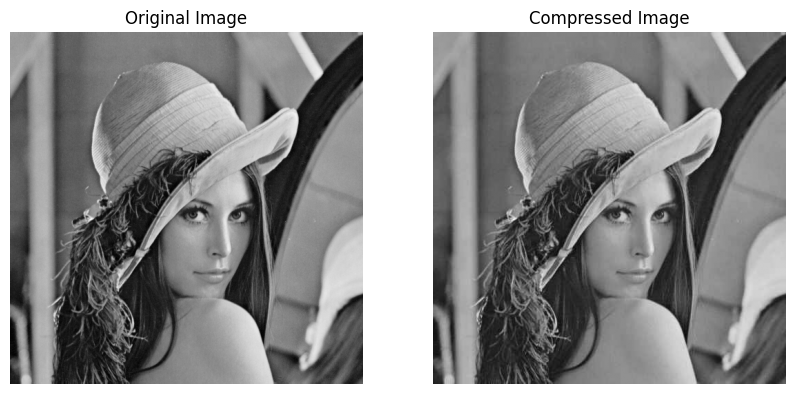

In [7]:
# Apply block-wise DCT
dct_image = blockwise_dct(padded_image)

# Quantize the DCT coefficients block-wise
quantized_dct = blockwise_quantize_dct(dct_image, quant_matrix)

# Dequantize to get the approximate DCT coefficients
dequantized_dct = blockwise_dequantize_dct(quantized_dct, quant_matrix)

# Reconstruct the image using block-wise IDCT
image_reconstructed = blockwise_idct(dequantized_dct)

# Crop the reconstructed image back to the original size
image_reconstructed = image_reconstructed[:h, :w]

# Clip the values to be in the 8-bit range and convert to uint8
image_reconstructed = np.clip(image_reconstructed, 0, 255).astype(np.uint8)

# Display the original and the compressed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_reconstructed, cmap='gray')
plt.title('Compressed Image')
plt.axis('off')

plt.show()

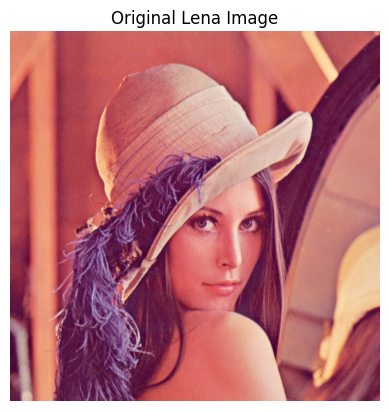

In [14]:
lena_image_path = 'Lena_Image.png'
lena_image = Image.open(lena_image_path)
plt.imshow(lena_image)
plt.title("Original Lena Image")
plt.axis('off')
plt.show()

In [15]:
# T1.1: Lossy Compression (JPEG)
def lossy_compression(image_path):
    image = Image.open(image_path)
    image.save("lossy_compressed.jpg", "JPEG", quality=30)
    print("Lossy compression (JPEG) completed. Saved as 'lossy_compressed.jpg'")
    return "lossy_compressed.jpg"

lossy_compression(lena_image_path)

Lossy compression (JPEG) completed. Saved as 'lossy_compressed.jpg'


'lossy_compressed.jpg'

In [16]:
# T1.2: Lossless Compression (PNG)
def lossless_compression(image_path):
    image = Image.open(image_path)
    image.save("lossless_compressed.png", "PNG")
    print("Lossless compression (PNG) completed. Saved as 'lossless_compressed.png'")
    return "lossless_compressed.png"

lossless_compression(lena_image_path)

Lossless compression (PNG) completed. Saved as 'lossless_compressed.png'


'lossless_compressed.png'

In [17]:
def build_cnn(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [18]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    cm = confusion_matrix(y_true, y_pred_classes)
    roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())

    return accuracy, precision, recall, f1, cm, fpr, tpr, roc_auc

In [19]:
def display_results(results, dataset_name):
    accuracy, precision, recall, f1, cm, fpr, tpr, roc_auc = results
    data = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'],
        dataset_name: [accuracy, precision, recall, f1, roc_auc]
    }
    df = pd.DataFrame(data)
    print(f"\nResults for {dataset_name}:")
    print(df.to_string(index=False))
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.legend(loc='lower right')
    plt.show()

In [20]:
# Apply CNN on MNIST dataset
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()
X_train_mnist = X_train_mnist.reshape(-1, 28, 28, 1) / 255.0
X_test_mnist = X_test_mnist.reshape(-1, 28, 28, 1) / 255.0
y_train_mnist = to_categorical(y_train_mnist)
y_test_mnist = to_categorical(y_test_mnist)

mnist_model = build_cnn((28, 28, 1), 10)
history_mnist = mnist_model.fit(X_train_mnist, y_train_mnist, epochs=50, validation_split=0.2)

Epoch 1/50


C:\Users\Tapassya Chaudhary\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8381 - loss: 0.5055 - val_accuracy: 0.9793 - val_loss: 0.0696
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9751 - loss: 0.0886 - val_accuracy: 0.9821 - val_loss: 0.0584
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9801 - loss: 0.0668 - val_accuracy: 0.9886 - val_loss: 0.0430
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9838 - loss: 0.0521 - val_accuracy: 0.9893 - val_loss: 0.0373
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9857 - loss: 0.0429 - val_accuracy: 0.9895 - val_loss: 0.0369
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9884 - loss: 0.0351 - val_accuracy: 0.9912 - val_loss: 0.0359
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9900 - loss: 0.0331 - val_accuracy: 0.9910 - val_loss: 0.0396
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9913 - loss: 0.0292 - val_accurac

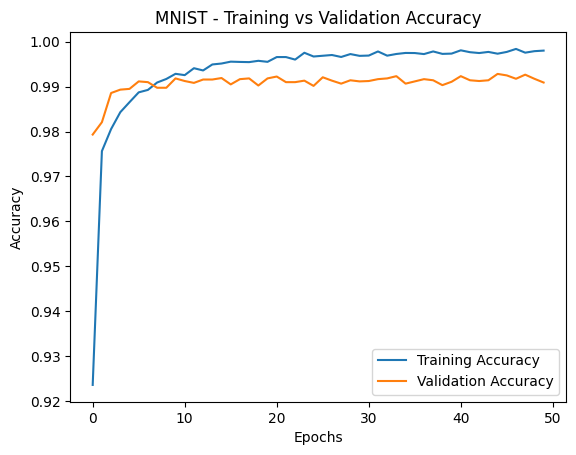

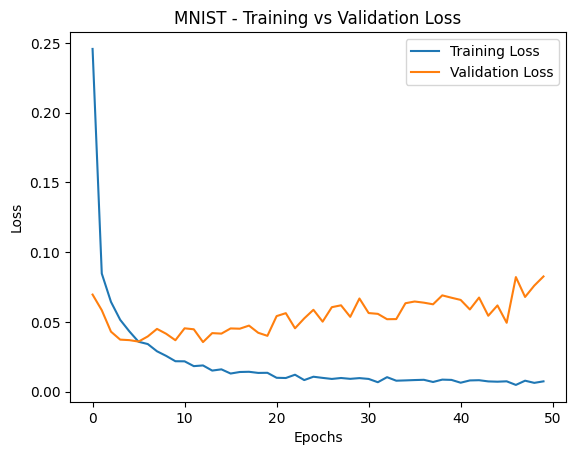

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Results for MNIST:
   Metric    MNIST
 Accuracy 0.992600
Precision 0.992618
   Recall 0.992600
 F1-Score 0.992601
  ROC AUC 0.999943


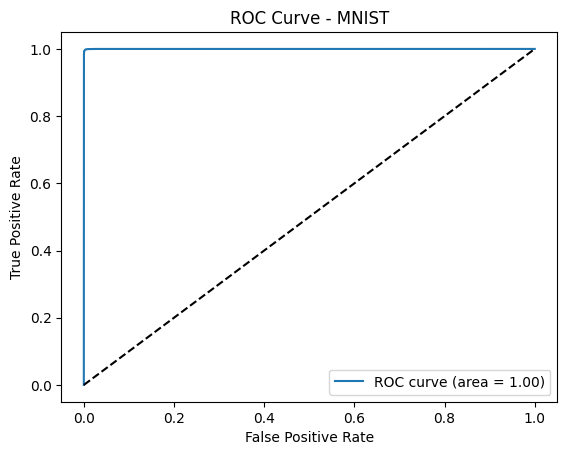

In [21]:
# Plot MNIST training/validation accuracy and loss
plt.figure()
plt.plot(history_mnist.history['accuracy'], label='Training Accuracy')
plt.plot(history_mnist.history['val_accuracy'], label='Validation Accuracy')
plt.title('MNIST - Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_mnist.history['loss'], label='Training Loss')
plt.plot(history_mnist.history['val_loss'], label='Validation Loss')
plt.title('MNIST - Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

mnist_results = evaluate_model(mnist_model, X_test_mnist, y_test_mnist)
display_results(mnist_results, "MNIST")

In [22]:
# Apply CNN on CIFAR-10 dataset
(X_train_cifar, y_train_cifar), (X_test_cifar, y_test_cifar) = cifar10.load_data()
X_train_cifar = X_train_cifar / 255.0
X_test_cifar = X_test_cifar / 255.0
y_train_cifar = to_categorical(y_train_cifar)
y_test_cifar = to_categorical(y_test_cifar)

cifar_model = build_cnn((32, 32, 3), 10)
history_cifar = cifar_model.fit(X_train_cifar, y_train_cifar, epochs=50, validation_split=0.2)

C:\Users\Tapassya Chaudhary\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.3049 - loss: 1.8725 - val_accuracy: 0.5188 - val_loss: 1.3354
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5096 - loss: 1.3663 - val_accuracy: 0.5860 - val_loss: 1.1734
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5772 - loss: 1.1944 - val_accuracy: 0.6199 - val_loss: 1.0933
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6091 - loss: 1.1008 - val_accuracy: 0.6398 - val_loss: 1.0225
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6397 - loss: 1.0402 - val_accuracy: 0.6598 - val_loss: 0.9664
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6577 - loss: 0.9856 - val_accuracy: 0.6692 - val_loss: 0.9599
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6699 - loss: 0.9399 - val_accuracy: 0.6734 - val_loss: 0.9263
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6877 - loss: 0.8932 -

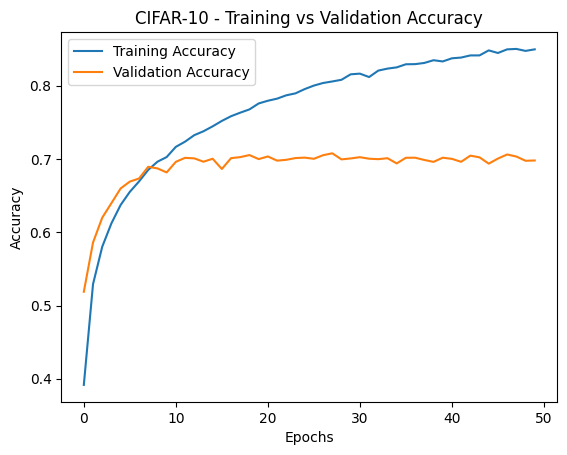

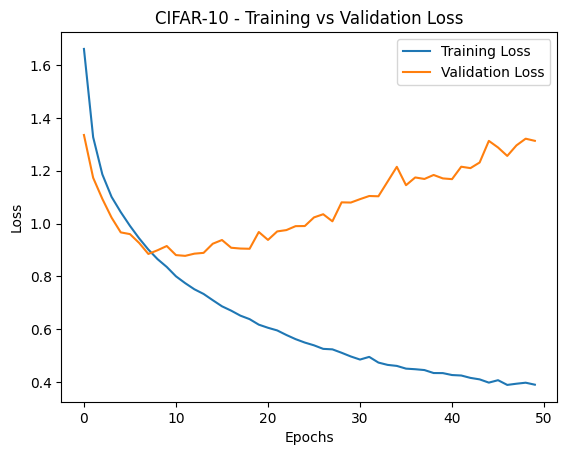

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Results for CIFAR-10:
   Metric  CIFAR-10
 Accuracy  0.696300
Precision  0.699327
   Recall  0.696300
 F1-Score  0.696759
  ROC AUC  0.949860


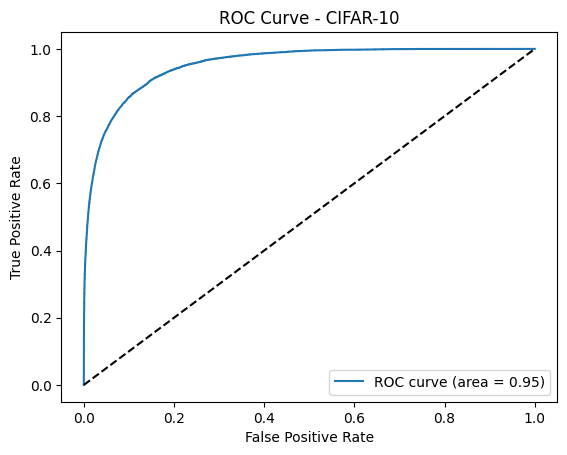

In [23]:
# Plot CIFAR-10 training/validation accuracy and loss
plt.figure()
plt.plot(history_cifar.history['accuracy'], label='Training Accuracy')
plt.plot(history_cifar.history['val_accuracy'], label='Validation Accuracy')
plt.title('CIFAR-10 - Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_cifar.history['loss'], label='Training Loss')
plt.plot(history_cifar.history['val_loss'], label='Validation Loss')
plt.title('CIFAR-10 - Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

cifar_results = evaluate_model(cifar_model, X_test_cifar, y_test_cifar)
display_results(cifar_results, "CIFAR-10")